In [37]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/all_vessel_calls.csv")

In [4]:
df.columns, df.shape

(Index(['arrivalDate', 'sailingDate', 'place.placeName', 'place.unlocode',
        'place.placeType', 'place.countryName', 'Timestamp', 'Event_Type',
        'IMO'],
       dtype='object'),
 (352968, 9))

In [147]:
code_df = pd.read_csv("../data/unlocode-list.csv", usecols=['Country', 'Location', 'Coordinates'])

In [148]:
code_df.columns, code_df.shape

(Index(['Country', 'Location', 'Coordinates'], dtype='object'), (116074, 3))

In [149]:
code_df['place.unlocode'] = code_df['Country'] + code_df['Location']

In [130]:
# display(df)

In [151]:
code_df.drop_duplicates(subset=['place.unlocode'])

,Country,Location,Coordinates,place.unlocode
0,AD,ALV,4230N 00131E,ADALV
1,AD,CAN,4234N 00135E,ADCAN
2,AD,ENC,4232N 00134E,ADENC
3,AD,ESC,4231N 00133E,ADESC
4,AD,EAC,4233N 00131E,ADEAC
...,...,...,...,...
116069,ZW,STH,1751S 03101E,ZWSTH
116070,ZW,THJ,1800S 02626E,ZWTHJ
116071,ZW,VFA,NaN,ZWVFA
116072,ZW,ZMZ,2016S 03055E,ZWZMZ


In [152]:
df.dropna(subset=['place.unlocode'])
code_df.dropna(subset=['place.unlocode'])

,Country,Location,Coordinates,place.unlocode
0,AD,ALV,4230N 00131E,ADALV
1,AD,CAN,4234N 00135E,ADCAN
2,AD,ENC,4232N 00134E,ADENC
3,AD,ESC,4231N 00133E,ADESC
4,AD,EAC,4233N 00131E,ADEAC
...,...,...,...,...
116069,ZW,STH,1751S 03101E,ZWSTH
116070,ZW,THJ,1800S 02626E,ZWTHJ
116071,ZW,VFA,NaN,ZWVFA
116072,ZW,ZMZ,2016S 03055E,ZWZMZ


In [169]:
merged_df = df.merge(code_df, on='place.unlocode')
# merged_df

In [170]:
morning_champ_df = merged_df[merged_df['IMO'] == 9285627]
glovis_sonic_df =  merged_df[merged_df['IMO'] == 9798387]

In [171]:
# visualize morning_champ_df
# convert coordinates
morning_champ_df[morning_champ_df['Coordinates'].isnull()]['place.placeName'].unique(), morning_champ_df[morning_champ_df['Coordinates'].isnull()]['place.unlocode'].unique()

(array([], dtype=object), array([], dtype=object))

In [172]:
# convert coordinates - seperate them into lat and log
morning_champ_df['lat'] = morning_champ_df['Coordinates'].apply(lambda x: x.split(' ')[0] if x else None)
morning_champ_df['lon'] = morning_champ_df['Coordinates'].apply(lambda x: x.split(' ')[1] if x  else None)
# # convert coordinates - read direction
morning_champ_df['lat'] = morning_champ_df['lat'].apply(lambda x: '-' + x[:-1] if x[-1:] == 'S' else x[:-1])
morning_champ_df['lon'] = morning_champ_df['lon'].apply(lambda x: '-' + x[:-1] if x[-1:] == 'W' else x[:-1])
# morning_champ_df

In [173]:
# convert to float with the last two digits being decimal points
def handle_lat_lon(x):
    if x:
        if '-' in x:
            return float(x[:-2]) + float(x[0] + x[-2:])/100
        else:
            return float(x[:-2]) + float(x[-2:])/100
    return None


morning_champ_df['lat'] = morning_champ_df['lat'].apply(lambda x: handle_lat_lon(x))
morning_champ_df['lon'] = morning_champ_df['lon'].apply(lambda x: handle_lat_lon(x))
# print(morning_champ_df.to_string())

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_22044\3927935859.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


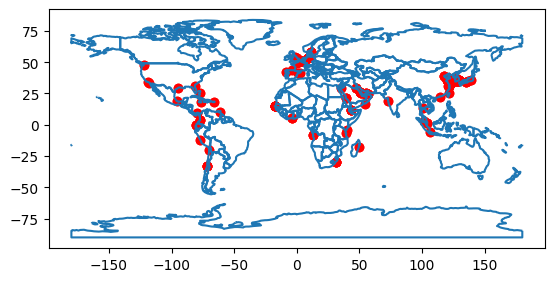

In [178]:
# convert to geopandas and plot, add arrow form the each point to the next, to show the path
gdf = geopandas.GeoDataFrame(morning_champ_df, geometry=geopandas.points_from_xy(morning_champ_df.lon, morning_champ_df.lat))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.boundary.plot()
gdf.plot(ax=ax, color='red')
plt.show()

In [180]:
morning_champ_df = morning_champ_df.sort_values(by='Timestamp')

In [187]:
from shapely.geometry import LineString

lines = []
for row in morning_champ_df.itertuples():
  # Assuming 'lon' and 'lat' are column names
  start_point = (row.lon, row.lat)
  if row.Index < len(morning_champ_df):  # Check if not the last row
    next_row = morning_champ_df.iloc[row.Index]  # Access next row using index
    end_point = (next_row['lon'], next_row['lat'])
    lines.append(LineString([start_point, end_point]))

gdf_lines = geopandas.GeoDataFrame({'geometry': lines})

C:\Users\SyeAli\AppData\Local\Temp\ipykernel_22044\742621661.py:2: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_lines.plot(ax=ax, color='blue', linewidth=2)


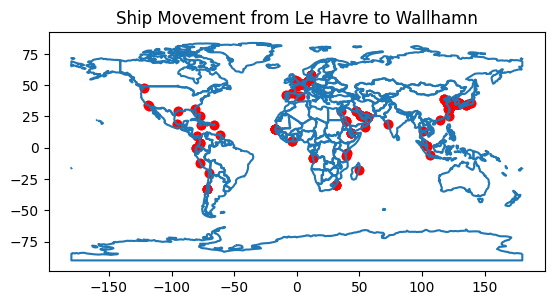

In [190]:
ax = world.boundary.plot()
gdf_lines.plot(ax=ax, color='blue', linewidth=2)
gdf.plot(ax=ax, color='red')
first_port = morning_champ_df[morning_champ_df['Timestamp'] == morning_champ_df['Timestamp'].min()]['place.placeName'].values[0]
last_port = morning_champ_df[morning_champ_df['Timestamp'] == morning_champ_df['Timestamp'].max()]['place.placeName'].values[0]
plt.title("Ship Movement from " + first_port + 
          " to " + last_port)
plt.show()